## Customized gymnasium environment: `smart-city`

In [1]:
import gymnasium
import matplotlib.pyplot as plt
# importing mobile_env automatically registers the predefined scenarios in Gym

In [2]:
import mobile_env
# predefined small scenarios
from mobile_env.scenarios.smart_city import MComSmartCity

# easy access to the default configuration
MComSmartCity.default_config()

{'width': 200,
 'height': 200,
 'EP_MAX_TIME': 100,
 'seed': 666,
 'reset_rng_episode': False,
 'arrival': mobile_env.core.arrival.NoDeparture,
 'channel': mobile_env.core.channels.OkumuraHata,
 'scheduler': mobile_env.core.schedules.RoundRobin,
 'movement': mobile_env.core.movement.RandomWaypointMovement,
 'utility': mobile_env.core.utilities.BoundedLogUtility,
 'handler': mobile_env.handlers.smart_city_handler.MComSmartCityHandler,
 'bs': {'bw': 100000000.0,
  'freq': 2500,
  'tx': 40,
  'height': 50,
  'computational_power': 100},
 'ue': {'velocity': 1.5, 'snr_tr': 2e-08, 'noise': 1e-09, 'height': 1.5},
 'sensor': {'height': 1.5,
  'snr_tr': 2e-08,
  'noise': 1e-09,
  'velocity': 0,
  'radius': 500,
  'logs': {}},
 'ue_job': {'job_generation_probability': 0.7,
  'communication_job_lambda_value': 2.875,
  'computation_job_lambda_value': 10.0},
 'sensor_job': {'communication_job_lambda_value': 1.125,
  'computation_job_lambda_value': 5.0},
 'e2e_delay_threshold': 5,
 'reward_calculati

In [3]:
from gymnasium.envs.registration import register

# Register the new environment
register(
    id='mobile-smart_city-smart_city_handler-v0',
    entry_point='mobile_env.scenarios.smart_city:MComSmartCity',  # Adjust this if the entry point is different
    kwargs={'config': {}, 'render_mode': None}
)

/home/elifohri/.local/lib/python3.10/site-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment mobile-smart_city-smart_city_handler-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [4]:
import gymnasium as gym

# List all registered environments
env_specs = gym.envs.registry.keys()
print(env_specs)

# Verify your specific environment is listed
assert 'mobile-smart_city-smart_city_handler-v0' in env_specs, "Environment not registered correctly"
print("Environment 'mobile-smart_city-smart_city_handler-v0' registered successfully!")

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'CartPoleJax-v0', 'CartPoleJax-v1', 'PendulumJax-v0', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'Jax-Blackjack-v0', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4', 'GymV21Environment-v0', 'GymV26Environment-v0', 'mobile-smart_city-smart_city_handler-v0'])
Environment 'mobile-smart_city-smart_city_handler-v0' registered suc

### Extending `mobile-env`: Tracking custom metrics

`mobile-env` allows to define and track custom metrics during the training and testing phases. It defines an interface for metrics that record values per user equipment and per sensor (e.g. utility per device), basestation (e.g. number of connections per station) or time step (e.g. average utility of device).

Here, we show as an example how the number of overall connections, connections per station and utility per device can be monitored. Also, we track each device's distance to the closest station. Later, we load the monitored metrics as `pandas` data frames.

In [5]:
import numpy as np

# overall number of active connections for UEs
def overall_connections(sim):
    return sum([len(conns) for conns in sim.connections.values()])

# overall number of active connections for sensors
def overall_connections_sensor(sim):
    return sum(len(conns) for conns in sim.connections_sensor.values())


# monitors utility per user equipment
def user_utility(sim):
    return {ue.ue_id: utility for ue, utility in sim.utilities.items()}

# monitors utility per sensor
def user_utility_sensor(sim):
    return {sensor.sensor_id: utility for sensor, utility in sim.utilities_sensor.items()}


# monitors each user equipment's distance to their closest base station
def user_closest_distance(sim):
    # position vector of basestation
    bs = next(iter(sim.stations.values()))  # Get the single base station
    bpos = np.array([bs.x, bs.y])  # Base station position as a vector


    distances = {}    
    for ue_id, ue in sim.users.items():
        upos = np.array([[ue.x, ue.y]])
        dist = np.sqrt(np.sum((bpos - upos)**2))
        
        distances[ue_id] = dist
    
    return distances

# monitors each sensor's distance to their closest base station
def sensor_closest_distance(sim):
    # position vector of basestations
    bs = next(iter(sim.stations.values()))  # Get the single base station
    bpos = np.array([bs.x, bs.y])  # Base station position as a vector

    distances = {}    
    for sensor_id, sensor in sim.sensors.items():
        spos = np.array([[sensor.x, sensor.y]])
        dist = np.sqrt(np.sum((bpos - spos)**2))
        
        distances[sensor_id] = dist
    
    return distances


# number of UE connections per basestation
def station_connections_ue(sim):
    return {bs.bs_id: len(conns) for bs, conns in sim.connections.items()}

# number of sensor connections per basestation
def station_connections_sensor(sim):
    return {bs.bs_id: len(conns) for bs, conns in sim.connections_sensor.items()}

In [6]:
# add custom metrics to config of environment
config = {"metrics": {
            "scalar_metrics": {"overall connections": overall_connections, "overall connections sensors": overall_connections_sensor},
            "ue_metrics": {"distance station": user_closest_distance, "user utility": user_utility},
            "bs_metrics": {"station connections UE": station_connections_ue,"station connections sensors": station_connections_sensor},
            "ss_metrics": {"distance station sensors": sensor_closest_distance, "user utility sensor": user_utility_sensor}
            }
         }

In [7]:
# create a small mobile environment for a single, centralized control agent
# pass rgb_array as render mode so the env can be rendered inside the notebook
env = gymnasium.make("mobile-smart_city-smart_city_handler-v0", config=config, render_mode="rgb_array")

print(f"\nSmart city environment with {env.NUM_USERS} users, {env.NUM_SENSORS} sensors and {env.NUM_STATIONS} cells.")


Smart city environment with 5 users, 15 sensors and 1 cells.


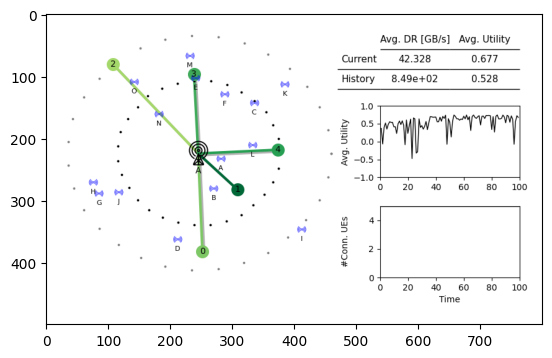

In [8]:
from IPython import display
import matplotlib.pyplot as plt

# run the simulation for 20 time steps
done = False
obs, info = env.reset()

total_episode_reward = 0
total_reward_over_time = []  # List to store the reward at each time step

for _ in range(100):
    # here, use random dummy actions by sampling from the action space
    dummy_action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(dummy_action)
    
    total_episode_reward += reward
    total_reward_over_time.append(total_episode_reward) 

    # render the environment
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    

In [9]:
total_reward_over_time

[30.0,
 49.0,
 59.0,
 112.2,
 137.4,
 162.60000000000002,
 202.57000000000002,
 221.57000000000002,
 221.57000000000002,
 304.74,
 331.713,
 356.64480000000003,
 369.76680000000005,
 381.57660000000004,
 414.6084000000001,
 434.80315800000005,
 445.4319780000001,
 450.7463880000001,
 466.1581770000001,
 472.0630770000001,
 472.0630770000001,
 502.2436770000001,
 502.2436770000001,
 515.3656770000001,
 515.3656770000001,
 557.6476770000002,
 557.6476770000002,
 621.8806770000001,
 635.7316770000001,
 656.8726770000001,
 664.162677,
 664.162677,
 664.162677,
 666.262677,
 666.262677,
 660.262677,
 642.262677,
 633.262677,
 633.262677,
 615.262677,
 606.262677,
 600.262677,
 594.262677,
 591.262677,
 567.262677,
 549.262677,
 537.262677,
 528.262677,
 525.262677,
 510.26267700000005,
 498.26267700000005,
 499.36005600000004,
 517.9790758800001,
 525.7274856600001,
 530.03215776,
 534.81512676,
 553.35175773,
 557.22596262,
 569.335361691,
 584.444760762,
 584.444760762,
 595.1813258868,
 

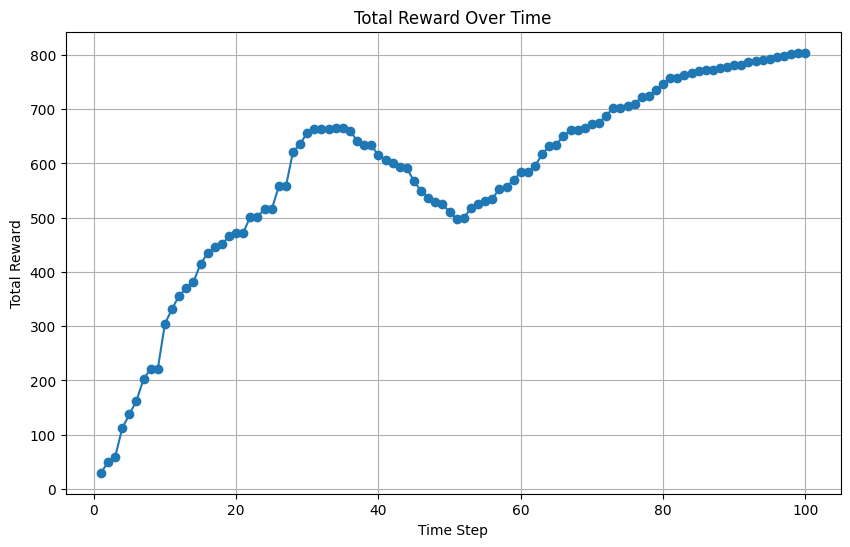

In [10]:
# Plot the reward over time
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(total_reward_over_time) + 1), total_reward_over_time, marker='o')
plt.title('Total Reward Over Time')
plt.xlabel('Time Step')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

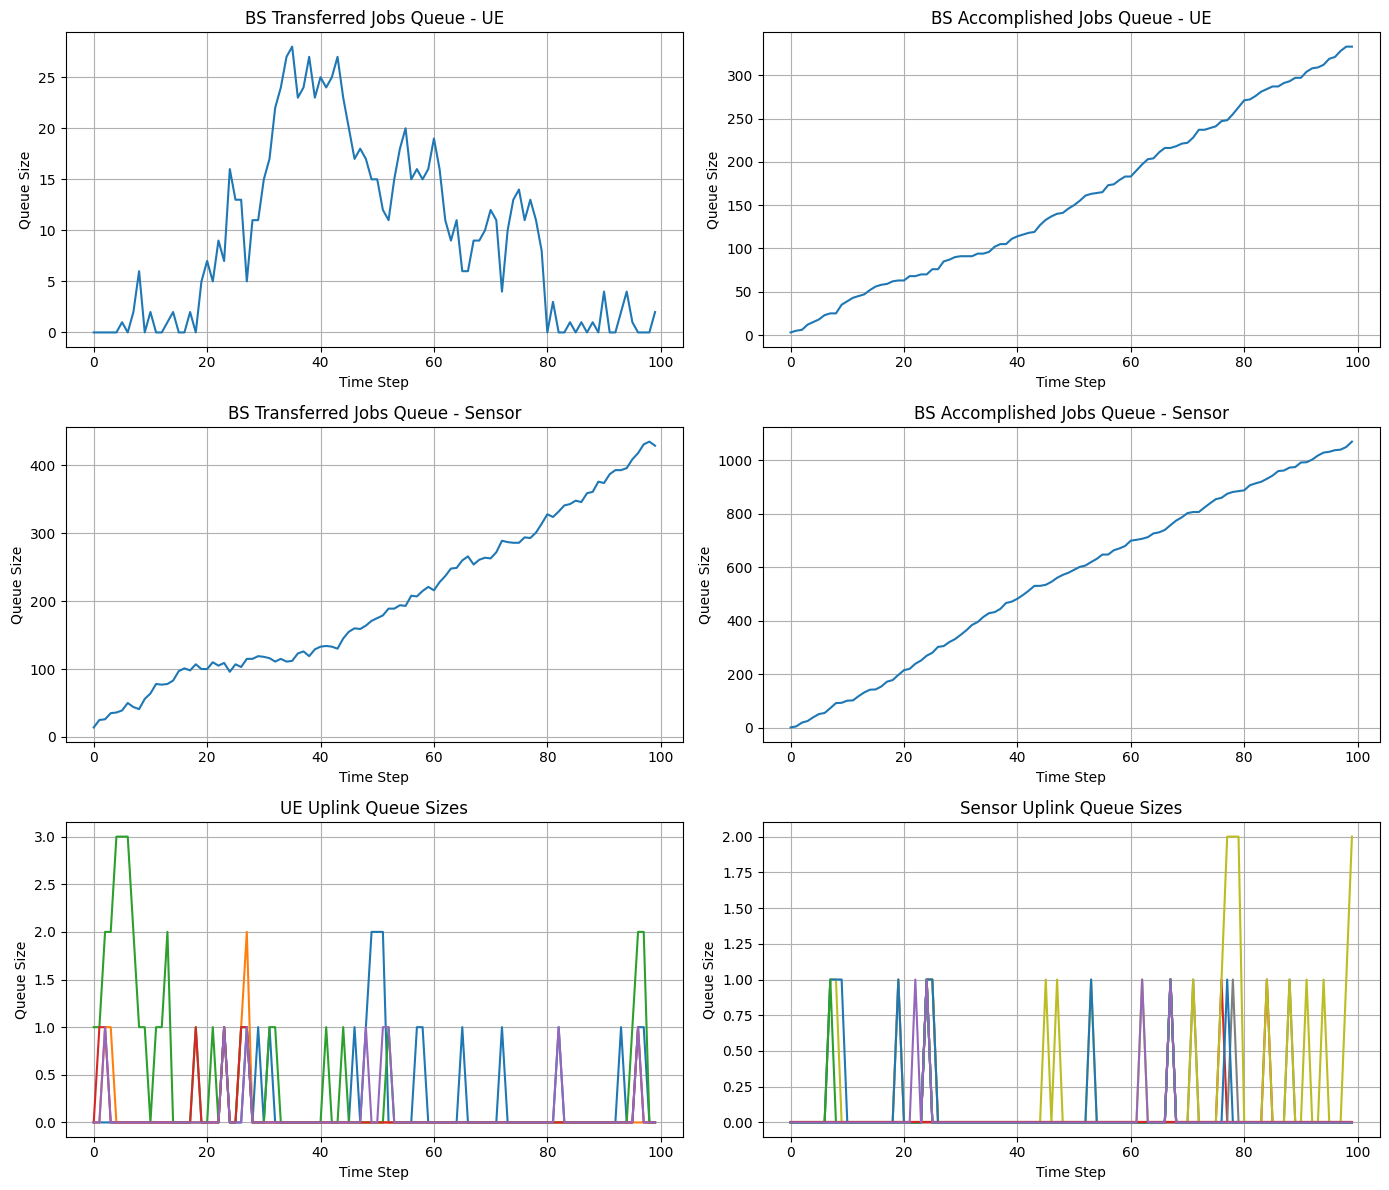

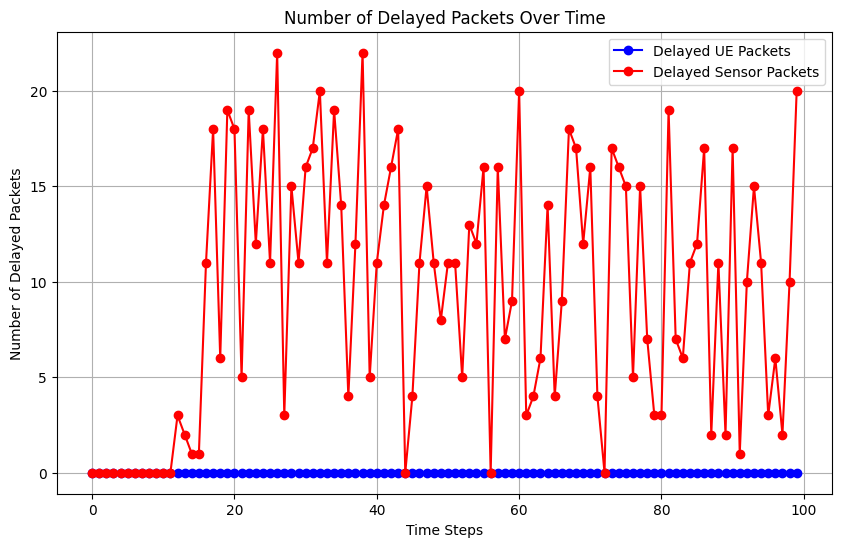

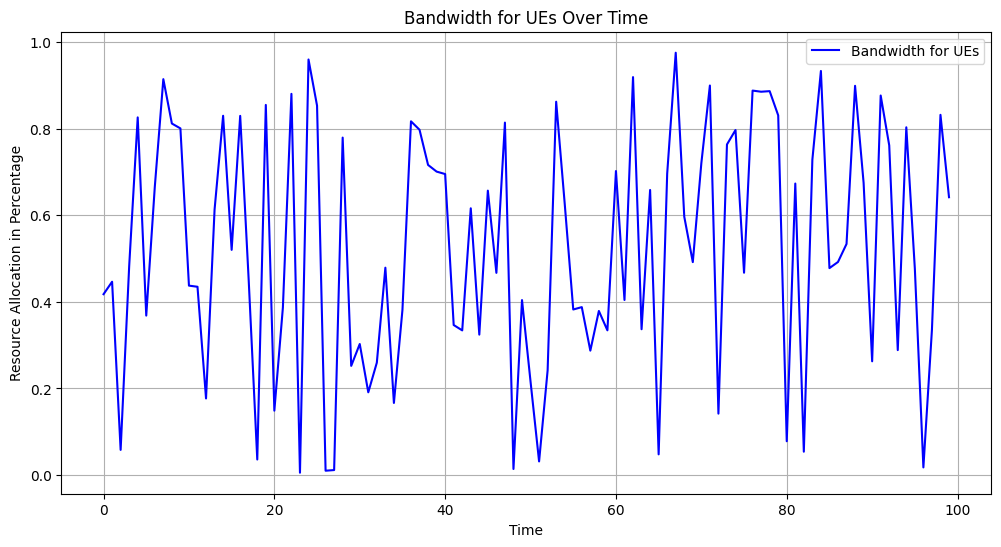

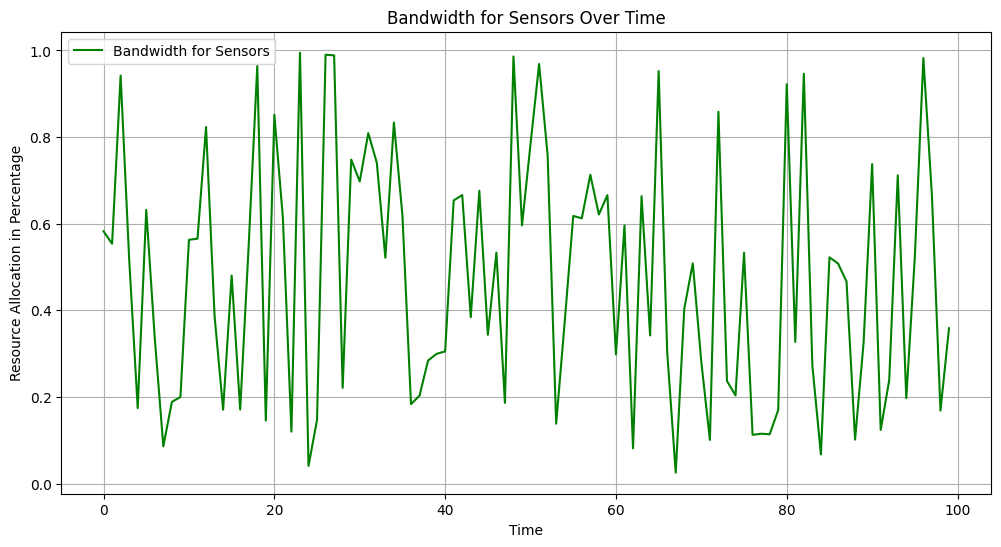

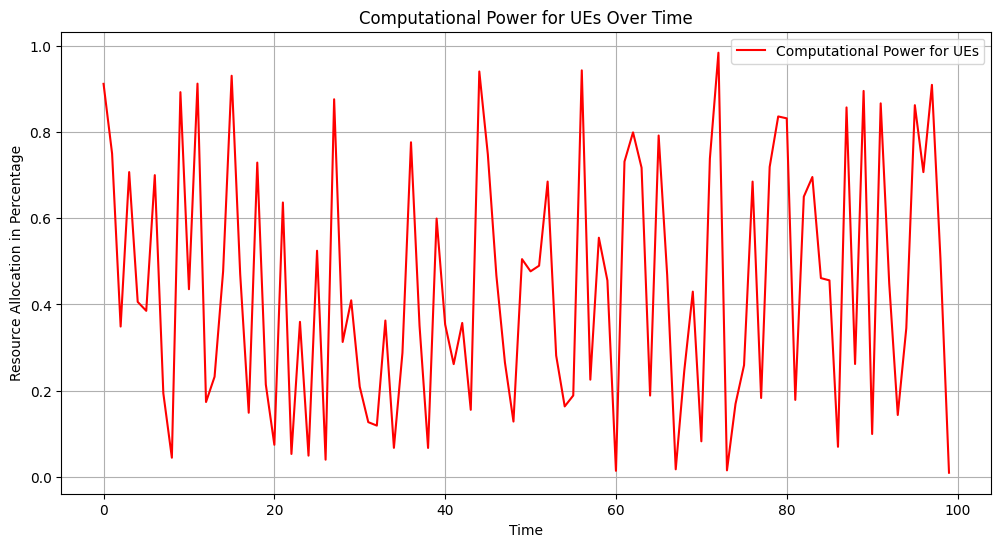

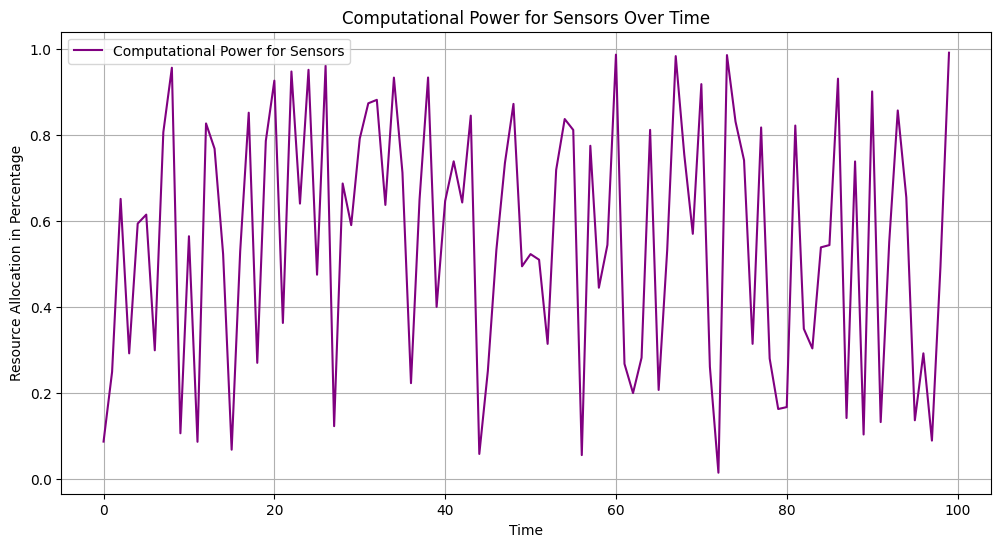

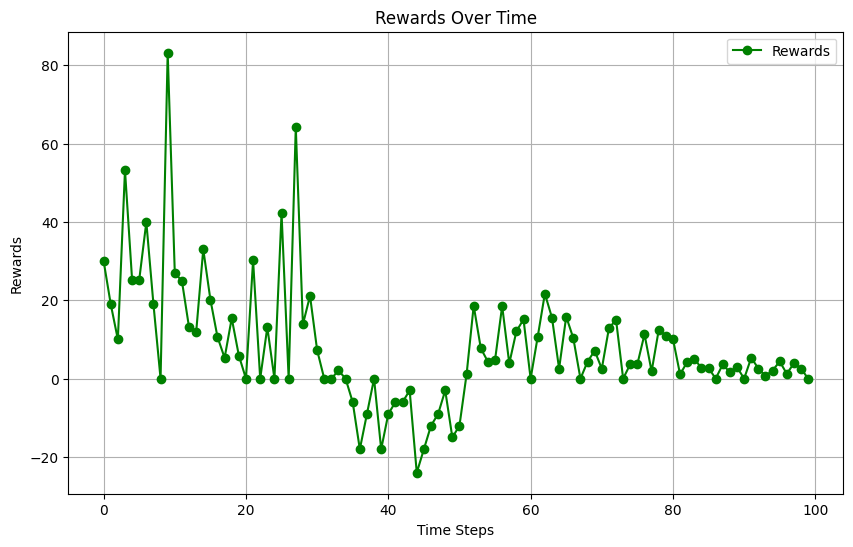

In [11]:
# Plot other environment metrics
env.plot_queue_sizes()
env.plot_delayed_packets()
env.plot_resource_allocations()
env.plot_rewards()

In [12]:

# load all tracked results as pandas data frames
scalar_results, ue_results, bs_results, ss_results = env.monitor.load_results()

# show general specific results
scalar_results.head()

,overall connections,overall connections sensors,number connections,number connections sensor,number connected,number connected sensor,mean utility,mean utility sensor,mean datarate,mean datarate sensor
Time Step,,,,,,,,,,
0,5,15,5,15,5,15,0.349765,0.696547,7.370745,184.829024
1,5,15,5,15,5,15,0.370850,0.687747,7.998407,175.699709
2,5,15,5,15,5,15,-0.067669,0.775299,1.021278,298.910545
3,5,15,5,15,5,15,0.396487,0.675783,8.518927,164.426972
4,5,15,5,15,5,15,0.519101,0.467907,14.525991,55.287127


In [13]:
ue_results

Metric           distance station  user utility
Time Step UE ID                                
0         0             58.457556      0.649032
          1            110.874807      0.194619
          2            122.207981      0.127942
          3             94.300447      0.311541
          4             75.313075      0.465692
...                           ...           ...
99        0             79.815138      0.524185
          1             38.566752      1.000000
          2             94.049429      0.402310
          3             63.562995      0.698774
          4             58.535843      0.759810

[500 rows x 2 columns]

In [14]:
ss_results

Metric               distance station sensors  user utility sensor
Time Step Sensor ID                                               
0         0                         16.492423             1.000000
          1                         30.083218             1.000000
          2                         57.280014             0.748454
          3                         70.611614             0.595007
          4                         61.032778             0.701916
...                                       ...                  ...
99        10                        83.546394             0.366283
          11                        39.623226             0.913348
          12                        79.227520             0.405207
          13                        42.520583             0.861593
          14                        74.027022             0.454997

[1500 rows x 2 columns]

In [15]:
bs_results

,Metric,station connections UE,station connections sensors
Time Step,BS ID,,
0,0,5,15
1,0,5,15
2,0,5,15
3,0,5,15
4,0,5,15
...,...,...,...
95,0,5,15
96,0,5,15
97,0,5,15


In [16]:
data = ue_results.reset_index()
data = data.groupby('UE ID').agg(['mean', 'min', 'max'])
data = data.drop('Time Step', axis='columns')
data.head()

Metric distance station                        user utility            \
                   mean        min         max         mean       min   
UE ID                                                                   
0             86.195208  58.457556   99.946785     0.354447 -0.545739   
1             47.532582   7.323860  110.874807     0.721224 -0.480736   
2             89.953579  77.179383  122.207981     0.333637 -0.660775   
3             49.517584  26.206380   94.300447     0.747590 -0.328090   
4             72.798475  58.535843   92.039596     0.483083 -0.360283   

Metric            
             max  
UE ID             
0       0.758628  
1       1.000000  
2       0.643941  
3       1.000000  
4       0.804002

In [17]:
data = ss_results.reset_index()
data = data.groupby('Sensor ID').agg(['mean', 'min', 'max'])
data = data.drop('Time Step', axis='columns')
data.head()

Metric    distance station sensors                       user utility sensor  \
                              mean        min        max                mean   
Sensor ID                                                                      
0                        16.492423  16.492423  16.492423            0.999769   
1                        30.083218  30.083218  30.083218            0.969623   
2                        57.280014  57.280014  57.280014            0.650813   
3                        70.611614  70.611614  70.611614            0.497366   
4                        61.032778  61.032778  61.032778            0.604275   

Metric                         
                min       max  
Sensor ID                      
0          0.976859  1.000000  
1          0.536073  1.000000  
2          0.063811  0.864664  
3         -0.089636  0.711217  
4          0.017274  0.818126

In [18]:
MComSmartCity.default_config()

{'width': 200,
 'height': 200,
 'EP_MAX_TIME': 100,
 'seed': 666,
 'reset_rng_episode': False,
 'arrival': mobile_env.core.arrival.NoDeparture,
 'channel': mobile_env.core.channels.OkumuraHata,
 'scheduler': mobile_env.core.schedules.RoundRobin,
 'movement': mobile_env.core.movement.RandomWaypointMovement,
 'utility': mobile_env.core.utilities.BoundedLogUtility,
 'handler': mobile_env.handlers.smart_city_handler.MComSmartCityHandler,
 'bs': {'bw': 100000000.0,
  'freq': 2500,
  'tx': 40,
  'height': 50,
  'computational_power': 100},
 'ue': {'velocity': 1.5, 'snr_tr': 2e-08, 'noise': 1e-09, 'height': 1.5},
 'sensor': {'height': 1.5,
  'snr_tr': 2e-08,
  'noise': 1e-09,
  'velocity': 0,
  'radius': 500,
  'logs': {}},
 'ue_job': {'job_generation_probability': 0.7,
  'communication_job_lambda_value': 2.875,
  'computation_job_lambda_value': 10.0},
 'sensor_job': {'communication_job_lambda_value': 1.125,
  'computation_job_lambda_value': 5.0},
 'e2e_delay_threshold': 5,
 'reward_calculati

### Extending `mobile-env`: Tracking custom metrics

import numpy as np

# overall number of active connections for UEs
def overall_connections(sim):
    return sum([len(conns) for conns in sim.connections.values()])

# overall number of active connections for sensors
def overall_connections_sensors(sim):
    return sum(len(conns) for conns in sim.connections_sensor.values())


# monitors utility per user equipment
def user_utility(sim):
    return {ue.ue_id: utility for ue, utility in sim.utilities.items()}

# monitors utility per user equipment
def user_utility(sim):
    return {sensor.sensor_id: utility for sensor, utility in sim.utilities.items()}


# monitors each user equipment's distance to their closest base station
def user_closest_distance(sim):
    # position vector of basestation
    bs = next(iter(sim.stations.values()))  # Get the single base station
    bpos = np.array([bs.x, bs.y])  # Base station position as a vector


    distances = {}    
    for ue_id, ue in sim.users.items():
        upos = np.array([[ue.x, ue.y]])
        dist = np.sqrt(np.sum((bpos - upos)**2))
        
        distances[ue_id] = dist
    
    return distances

# monitors each sensor's distance to their closest base station
def user_closest_distance_sensor(sim):
    # position vector of basestations
    bs = next(iter(sim.stations.values()))  # Get the single base station
    bpos = np.array([bs.x, bs.y])  # Base station position as a vector

    distances = {}    
    for sensor_id, sensor in sim.sensors.items():
        spos = np.array([[sensor.x, sensor.y]])
        dist = np.sqrt(np.sum((bpos - spos)**2))
        
        distances[sensor_id] = dist
    
    return distances


# number of UE connections per basestation
def station_connections(sim):
    return {bs.bs_id: len(conns) for bs, conns in sim.connections.items()}

# number of sensor connections per basestation
def station_connections_sensor(sim):
    return {bs.bs_id: len(conns) for bs, conns in sim.connections_sensor.items()}

# add custom metrics to config of environment
config = {"metrics": {
            "scalar_metrics": {"overall connections": overall_connections},
            "ue_metrics": {"distance station": user_closest_distance},
            "bs_metrics": {"station connections": station_connections}
            }
         }

# load all tracked results as pandas data frames
scalar_results, ue_results, bs_results = env.monitor.load_results()

# show general specific results
scalar_results.head()

### Environment Data

In [19]:
obs, info = env.reset()
print("obs:", obs)
print("info:", info)

print("\nMetadata")
print("metadata:", env.metadata)

print("\nRender Modes")
print("render modes:", env.render_mode)

print("\nSpec:")
print("spec:", env.spec)

print("\nAction Space")
print("action space:", env.action_space)
print("action space shape:", env.action_space.shape)
print("simple action:", env.action_space.sample())

print("\nObservation Space")
print("observation space:", env.observation_space)
print("observation space shape:", env.observation_space.shape)
print("sample observation:", env.observation_space.sample())

print("\nReward Range")
print("reward range:", env.reward_range)

env.close()

obs: [0. 0. 0. 0. 0. 0.]
info: {}

Metadata
metadata: {'render_modes': ['rgb_array', 'human']}

Render Modes
render modes: rgb_array

Spec:
spec: EnvSpec(id='mobile-smart_city-smart_city_handler-v0', entry_point='mobile_env.scenarios.smart_city:MComSmartCity', reward_threshold=None, nondeterministic=False, max_episode_steps=None, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={'config': {'metrics': {'scalar_metrics': {'overall connections': <function overall_connections at 0x7211ec30e9e0>, 'overall connections sensors': <function overall_connections_sensor at 0x7211ec30e7a0>}, 'ue_metrics': {'distance station': <function user_closest_distance at 0x7211ec30ecb0>, 'user utility': <function user_utility at 0x7211ec30eb90>}, 'bs_metrics': {'station connections UE': <function station_connections_ue at 0x7211ec30edd0>, 'station connections sensors': <function station_connections_sensor at 0x7211ec30ee60>}, 'ss_metrics': {'distance statio